In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model



# Set dataset paths
dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# Image parameters
image_size = (224, 224)
batch_size = 32

# Data Generators
train_datagen_no_aug = ImageDataGenerator(rescale=1./255)
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_no_aug = train_datagen_no_aug.flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=True)
val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=False)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=False)

# Class weights to handle imbalance
pneumonia_count = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))
normal_count = len(os.listdir(os.path.join(train_dir, "NORMAL")))
total_count = pneumonia_count + normal_count
class_weights = {
    0: total_count / (2 * normal_count),
    1: total_count / (2 * pneumonia_count)
}

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_resnet50_with_gradcam(fine_tune_layers=5):
    input_tensor = Input(shape=(224, 224, 3))
    
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=input_tensor)

    for layer in base_model.layers[:-fine_tune_layers]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=input_tensor, outputs=output)

    optimizer = Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    # Grad-CAM model — outputs conv layer and predictions
    grad_model = Model(
        inputs=model.input,
        outputs=[
            base_model.get_layer("conv5_block3_out").output,  # last conv layer
            model.output
        ]
    )

    return model, grad_model



In [4]:
resnet_noaug, grad_model_resnet_noaug = build_resnet50_with_gradcam()

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Train model
history_resnet_aug = resnet_noaug.fit(
    train_generator_no_aug,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 324ms/step - accuracy: 0.5887 - loss: 1.1681 - val_accuracy: 0.5625 - val_loss: 1.1154 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 296ms/step - accuracy: 0.7297 - loss: 0.9732 - val_accuracy: 0.5625 - val_loss: 1.0304 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 291ms/step - accuracy: 0.7896 - loss: 0.8777 - val_accuracy: 0.5625 - val_loss: 0.9695 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - accuracy: 0.8256 - loss: 0.8038 - val_accuracy: 0.5625 - val_loss: 0.9337 - learning_rate: 1.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 289ms/step - accuracy: 0.8345 - loss: 0.7545 - val_accuracy: 0.5625 - val_loss: 0.9636 - learning_rate: 1.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 290ms/step - accuracy: 0.8365 - loss: 0.7325 - val_accuracy: 0.5625 - val_loss: 0.9270 - learning_rate: 1.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 28

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import cv2

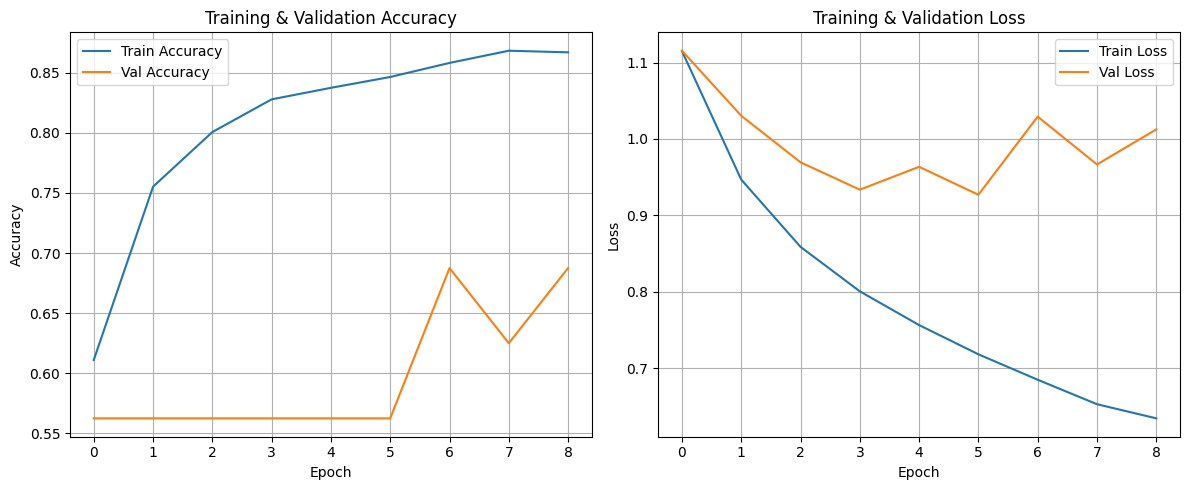

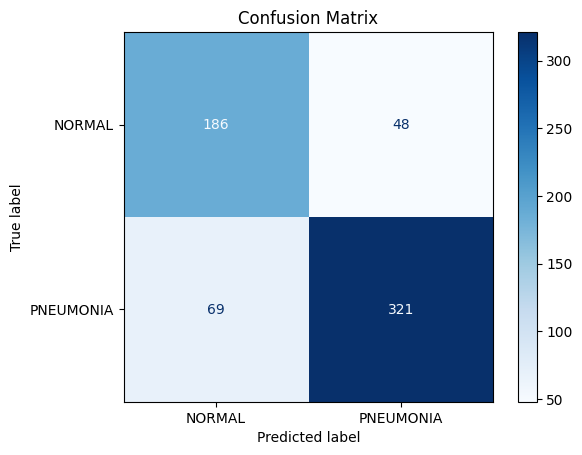

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.73      0.79      0.76       234
   PNEUMONIA       0.87      0.82      0.85       390

    accuracy                           0.81       624
   macro avg       0.80      0.81      0.80       624
weighted avg       0.82      0.81      0.81       624



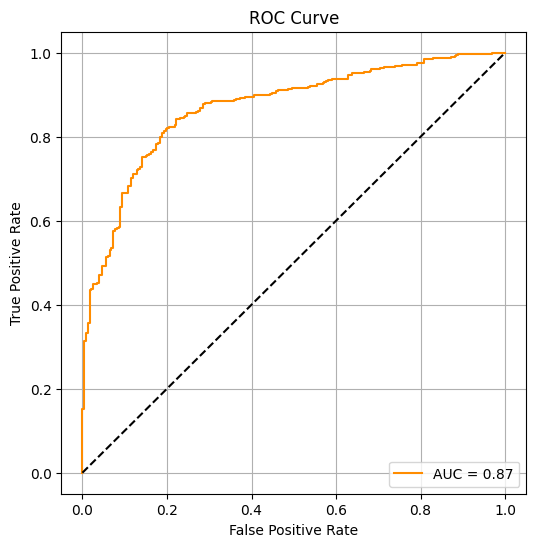

In [15]:
# Predict on test set
y_pred_prob = resnet_noaug.predict(test_generator, verbose=0)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Accuracy & Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet_aug.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_resnet_aug.history['loss'], label='Train Loss')
plt.plot(history_resnet_aug.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()






In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=0)
    return img_array, img

def grad_cam(model, grad_model, img_array):
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    pooled_grads = pooled_grads.numpy()
    conv_output = conv_output.numpy()

    heatmap = np.dot(conv_output, pooled_grads)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap + 1e-8)  # prevent division by 0
    heatmap = cv2.resize(heatmap, (224, 224))

    return heatmap

def display_grad_cam(img_path, model, grad_model):
    img_array, original_img = preprocess_image(img_path)
    heatmap = grad_cam(model, grad_model, img_array)

    plt.imshow(original_img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Grad-CAM')
    plt.show()


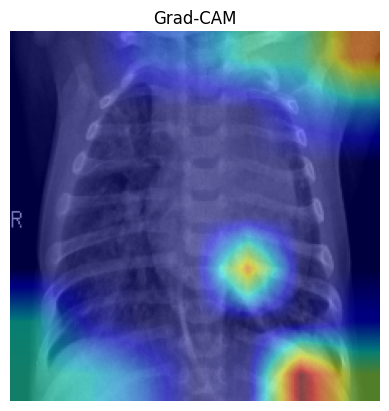

In [20]:
img_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"
display_grad_cam(img_path, resnet_noaug, grad_model_resnet_noaug)
